In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys

sys.path.append('/opt/app')

from fastfmri_toolbox.stimulus.stimulus import Stimulus

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm as CM
cm, DPI = 1 / 2.54, 200

### Instantiate stimulus object

In [2]:
TR = .3
n_timepoints = 800
stimulus_amplitude = .5
stimulus_start_time = 14
stimulus_duration = 185
stimulus_frequencies = .125

stim = Stimulus(TR,n_timepoints,stimulus_start_time,stimulus_duration,stimulus_frequencies,stimulus_amplitude=1.,stimulus_start_on=True)

### Plot stimulus

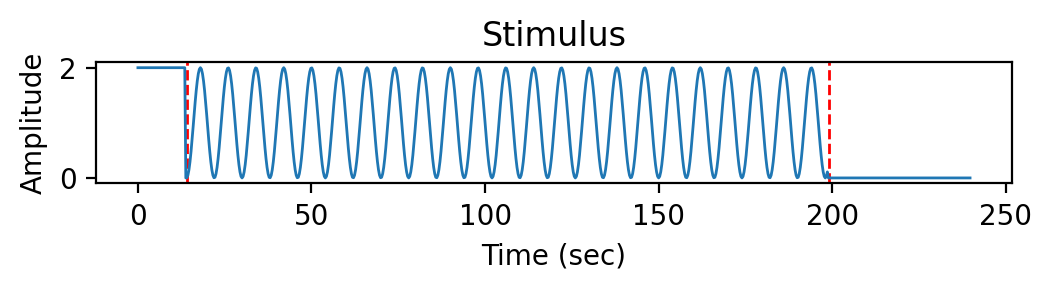

In [3]:
x,y = stim.generate()

# Plot
fig, ax = plt.subplots(figsize=(15*cm,2*cm),dpi=DPI)
_ = ax.plot(x,y,lw=1.,zorder=10)



ax.axvline(x=stim.start_time,lw=1.,c='red',linestyle='--',zorder=1)
ax.axvline(x=stim.end_time,lw=1.,c='red',linestyle='--',zorder=1)

_ = ax.set_title('Stimulus')
_ = ax.set_xlabel('Time (sec)')
_ = ax.set_ylabel('Amplitude')

## Lets plot some hemodynamic response functions (HRF)

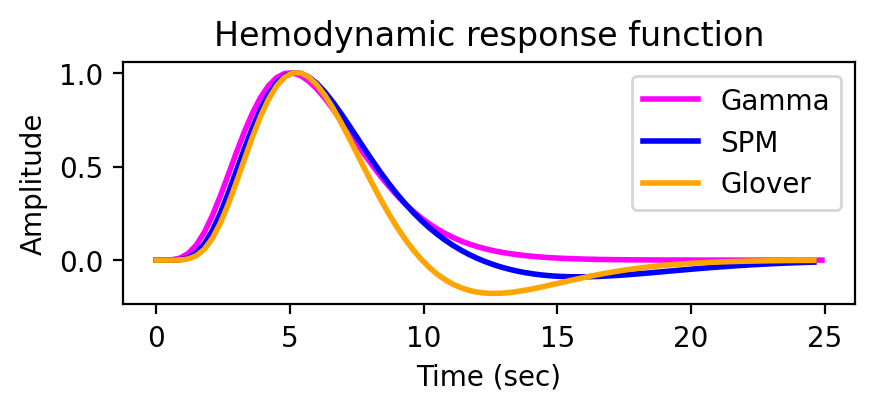

In [4]:

from nilearn.glm.first_level.hemodynamic_models import (
    spm_hrf,
    glover_hrf
)

hrf, time, c = {}, {}, {}
oversampling, time_length = 1, 25

"""
Gamma
"""
def gamma_hrf(
    TR,
    oversampling=50,
    time_length=25,
    gamma_k = 6,
    normalize=True,
):
    
    from scipy.stats import gamma
    
    time = np.arange(0,time_length,TR/oversampling)
    hrf = gamma.pdf(time, gamma_k)
    if normalize:
        hrf *= 1./hrf.max()
        
    return hrf, time

hrf_type = 'Gamma'
c[hrf_type] = 'magenta'
    
hrf[hrf_type], time[hrf_type] = gamma_hrf(
    TR,
    oversampling=oversampling,
    time_length=time_length,
)

"""
SPM
"""
hrf_type = 'SPM'
c[hrf_type] = 'blue'

hrf[hrf_type]= spm_hrf(
    TR,
    oversampling=oversampling,
    time_length=time_length,
)
hrf[hrf_type] *= 1./hrf[hrf_type].max() # normalize
time[hrf_type] = np.arange(0,hrf[hrf_type].shape[0]*(TR/oversampling),(TR/oversampling))

"""
Glover
"""
hrf_type = 'Glover'
c[hrf_type] = 'orange'

hrf[hrf_type]= glover_hrf(
    TR,
    oversampling=oversampling,
    time_length=time_length,
)
hrf[hrf_type] *= 1./hrf[hrf_type].max() # normalize
time[hrf_type] = np.arange(0,hrf[hrf_type].shape[0]*(TR/oversampling),(TR/oversampling))

"""
Plot
"""
fig,ax = plt.subplots(figsize=(12*cm,4*cm),dpi=DPI)
line = {}
for hrf_type in hrf.keys():
    line[hrf_type], = ax.plot(
        time[hrf_type],
        hrf[hrf_type],
        c=c[hrf_type],
        lw=2,
        label=hrf_type
    )

_ = ax.legend(handles=[i for _,i in line.items()])
_ = ax.set_title('Hemodynamic response function')
_ = ax.set_xlabel('Time (sec)')
_ = ax.set_ylabel('Amplitude')

## Convolve stimulus with HRF

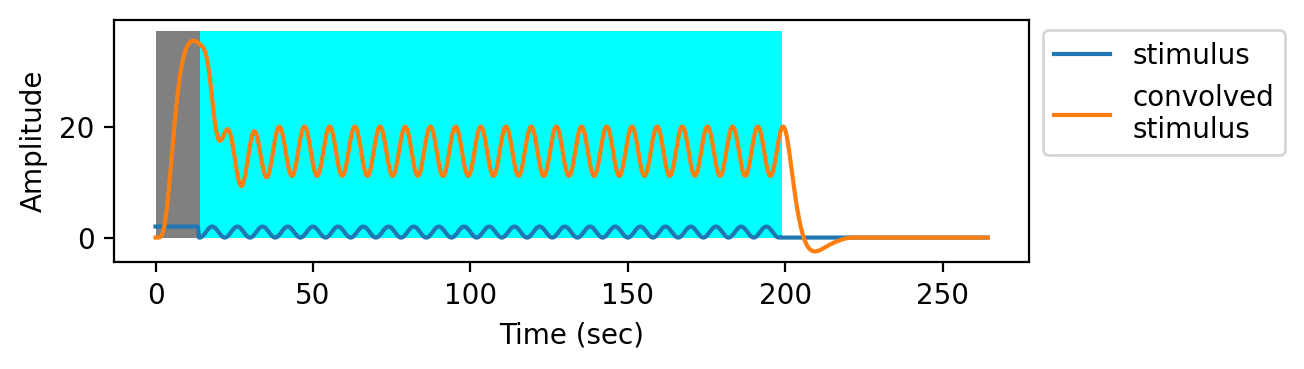

In [5]:
time, stim_signal, stim_convolved = stim.convolve(hrf['SPM'])

# Plot
fig,ax = plt.subplots(figsize=(15*cm,4*cm),dpi=DPI)

l1, = ax.plot(time,stim_signal,label='stimulus',zorder=10)
l2, = ax.plot(time,stim_convolved,label='convolved\nstimulus',zorder=10) 

rect = {}
_max = max(stim_signal.max(),stim_convolved.max())
_max += .05 * _max
rect['stim_off'] = patches.Rectangle((0,0),stimulus_start_time,_max,fc='grey',zorder=5)
rect['stim_on'] = patches.Rectangle((stimulus_start_time,0),stim.duration,_max,fc='cyan',zorder=5)
for annot, _rect in rect.items():
    ax.add_patch(_rect)

_ = ax.legend(handles=[l1,l2],loc='center left',bbox_to_anchor=(1,.7))
_ = ax.set_xlabel('Time (sec)')
_ = ax.set_ylabel('Amplitude')